In [55]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import requests
from bs4 import BeautifulSoup
import re
import io 
import os
import sys
import pandas as pd
import time
from tqdm import tqdm
import json

In [56]:
options = Options()
#options.add_argument("--headless")
browser = webdriver.Chrome(service=Service("./chromedriver.exe"), options=options)
browser.get('https://openreview.net/group?id=ICLR.cc/2024/Conference')

In [69]:
def extract_paper(soup):
    result = {'name': soup.find_all('h2')[0].text}
    reviews = []
    j = -1
    for i, content in enumerate(soup.find_all(name='span', attrs={'class':"note-content-value"})):
        if i == 0:
            result['key_word'] = content.text.split(',')
            continue
        if i < 6:
            continue
        if j == -1:
            try:
                result['sn'] = int(content.text)
                j = 0
                continue
            except:
                continue
        number = re.findall("\d+", content.text[:3])
        if j % 7 == 0:
            review = {'mark': [int(number[0])]}
        elif j % 7 in [1, 2]:
            
            review['mark'].append(int(number[0]))
        elif j % 7 == 4:
            review['rate'] = int(number[0])
        elif j % 7 == 5:
            review['confidence'] = int(number[0])
            reviews.append(review)
        j += 1
    result['reviews'] = reviews  
    
    for i, content in enumerate(soup.find_all(name='div', attrs={'class':"note-content-value markdown-rendered"})):
        if i == 0:
            result['abstract'] = content.text
            result['detail'] = []
            continue
        if i % 4 == 1:
            review_detail = {'summary': content.text}
        if i % 4 == 2:
            review_detail['strengths'] = content.text
        if i % 4 == 3:
            review_detail['weaknesses'] = content.text
        if i % 4 == 0:
            review_detail['questions'] = content.text
            result['detail'].append(review_detail)
     
    return result

In [121]:
def goto_page(browser, page):
    ps = []
    while True:
        ps = []
        for l in browser.find_elements(By.XPATH, "//a[contains(@href, '#')]"):
            p = re.findall("\d+", l.text)
            if len(p):
                ps.append(int(p[0]))
        if page in ps:
            break
        el = None
        for k in browser.find_elements(By.XPATH, "//*[contains(text(),{})]".format(ps[-1]))[::-1]:
            if len (k.text):
                el = k
                break
        el.click()
        time.sleep(5)
    time.sleep(5)
    return browser

In [157]:
pages = range(1, 287)
links = []
for page in pages:
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    links.extend([link.get('href') for link in soup.find_all('a', href=re.compile("forum\?id*(?!.*&)"))])
    browser.find_element(By.XPATH, "//*[contains(text(),'›')]").click()
    """links = browser.find_elements(By.XPATH, "//a[contains(@href, 'forum')]")
    n = len(links)
    for i in range(n):
        link = links[i]
        if len(link.text):
            name = link.text
            print(name)
            link.click()
            time.sleep(5)
            soup = BeautifulSoup(browser.page_source, 'html.parser')
            result = extract_paper(soup)
            result['name'] = name
            df.append(result)
            browser.find_element(By.XPATH, "//a[contains(@title, 'Homepage')]").click()
            browser = goto_page(browser, page)
            links = browser.find_elements(By.XPATH, "//a[contains(@href, 'forum')]")"""
    # browser.find_element(By.XPATH, '//*[@id="0Q3gPpV3Z5"]/div/div/nav/ul/li[13]/a').click()
    time.sleep(5)

In [170]:
pd.DataFrame(links).to_csv('links.csv', header=['link'], index=False)

In [71]:
links = pd.read_csv('links.csv')['link']


In [7]:
with open('result.json', 'r') as f:
        results = json.load(f)

In [9]:
crawled = []
for result in results:
    crawled.append(result['name'])

In [74]:
results = []

In [75]:

errors = []
for i, link in enumerate(links):
    try:
        url = 'https://openreview.net/'
        if link[0] == '/':
            browser.get(url + link[1:])
        else:
            browser.get(url + link)
        
        time.sleep(5)
        soup = BeautifulSoup(browser.page_source, 'html.parser')
        
        results.append(extract_paper(soup))
        
        
        if len(results) % 10 == 0:
            with open('result.json', 'w') as f:
                json.dump(results, f)
        if i % 100 == 0:
            browser = webdriver.Chrome(service=Service("./chromedriver.exe"), options=options)
    except Exception as e:
        errors.append({'error': e, 'url': link})

In [76]:
with open('result.json', 'w') as f:
    json.dump(results, f)

In [77]:
with open('example.json', 'w') as f:
    json.dump(results[:20], f)

In [28]:
import numpy as np
rate = []
var = []
mark = []
for result in results:
    all_rate = np.array([x['rate'] for x in result['reviews']])
    if len(all_rate):
        rate.append(np.average(all_rate))
        var.append(np.max(all_rate) - np.min(all_rate))

    # mark.append(np.array([x['mark'] for x in result['reviews']]))

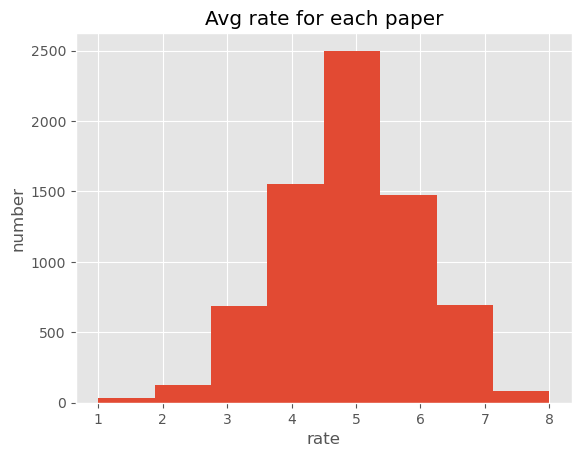

In [90]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(rate, bins=8)
plt.xlabel('rate')
plt.ylabel('number')
plt.title('Avg rate for each paper')
plt.show()

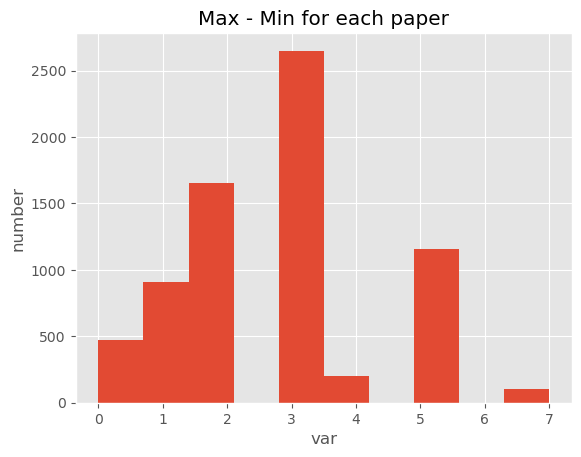

In [92]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist(var, bins=10)
plt.xlabel('var')
plt.ylabel('number')
plt.title('Max - Min for each paper')
plt.show()

In [93]:
title = ''
for result in results:
    title = title + result['name'] + ' '
    

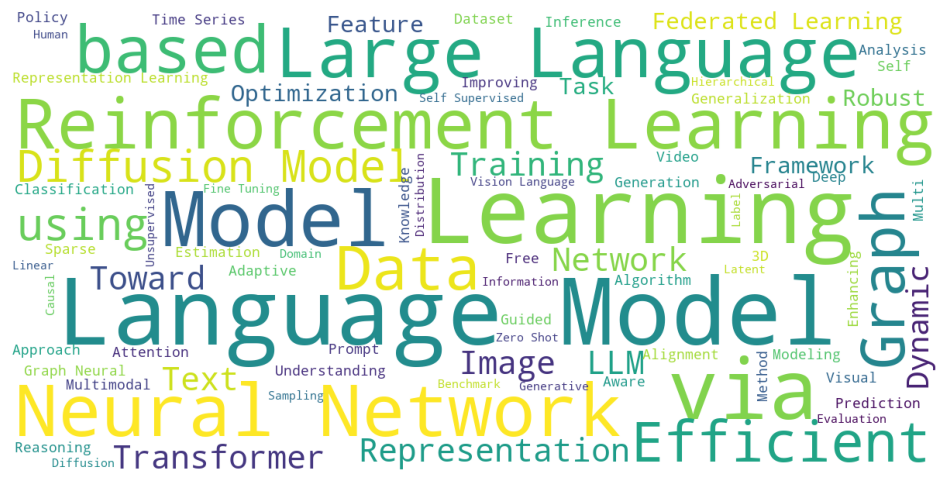

In [96]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=10
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(title)

In [129]:
'l models'[-5:]

'odels'

In [97]:
from collections import defaultdict
key_words = defaultdict()

for result in results:
    for key in result['key_word']:
        key = key.lower()
        if key[0] == ' ':
            key = key[1:]
        if key[-6:] == 'models':
            key = key[:-6] + 'model'
            
        if key in key_words:
            key_words[key] += 1
        else:
            key_words[key] = 1

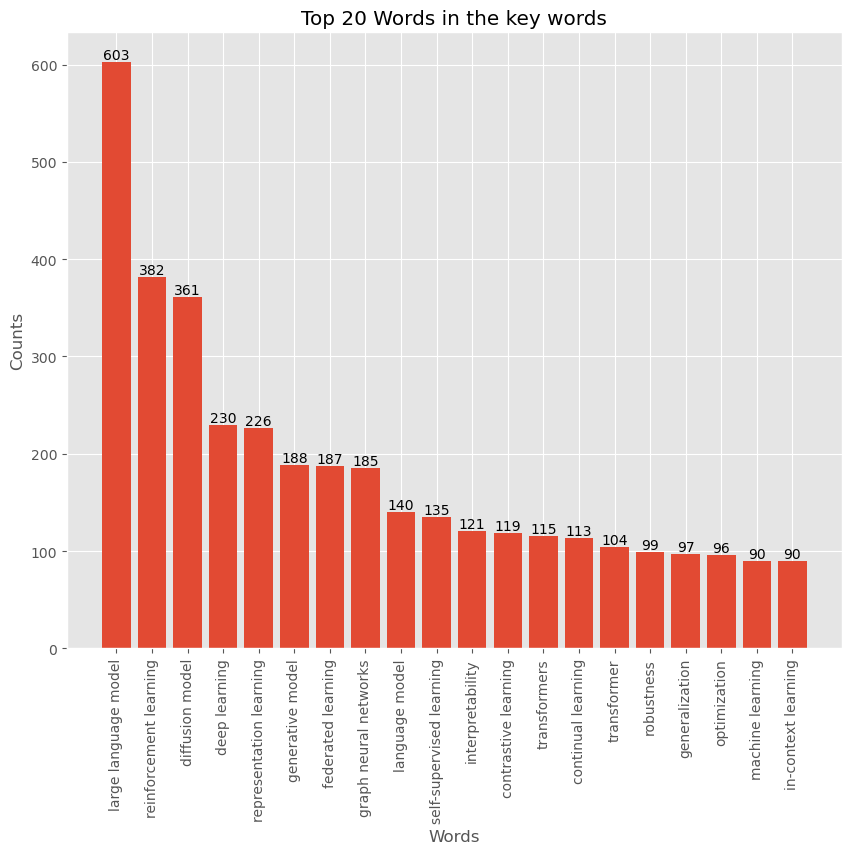

In [98]:
from collections import Counter
top_words = dict(Counter(key_words).most_common(20))

# Splitting the dictionary into keys and values
words = list(top_words.keys())
counts = list(top_words.values())

# Creating the plot
plt.figure(figsize=(10, 8))
bars = plt.bar(words, counts)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 20 Words in the key words')
plt.xticks(rotation=90)
plt.show()

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import json
import numpy as np

In [3]:
with open('result.json', 'r') as f:
    results = json.load(f)

In [17]:
rate = []
var = []
for result in results:
    if 'jailbreak' in result['name'].lower():
        all_rate = np.array([x['rate'] for x in result['reviews']])
        if len(all_rate):
            rate.append(np.average(all_rate))
            var.append(np.max(all_rate) - np.min(all_rate))

In [27]:
len(rate)

10

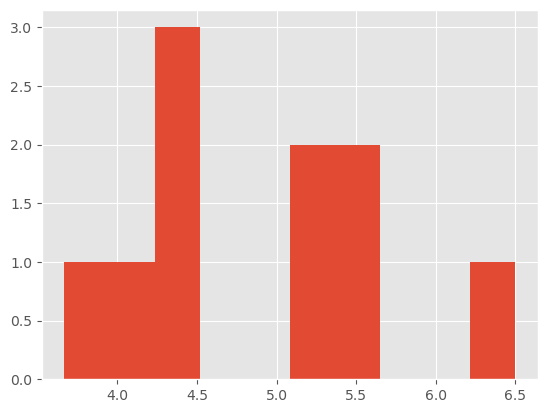

In [25]:
plt.hist(rate, bins=10)
plt.show()

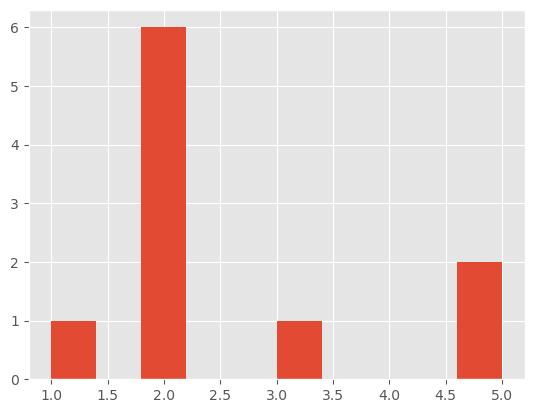

In [26]:
plt.hist(var, bins=10)
plt.show()

In [107]:
for i, result in enumerate(results):
        all_rate = np.array([x['rate'] for x in result['reviews']])
        """if len(all_rate):
            results[i]['avg_rate'] = str(np.average(all_rate))
            results[i]['var_rate'] = str(np.max(all_rate) - np.min(all_rate))
        else:
            results[i]['avg_rate'] = "0"
            results[i]['var_rate'] = "-1"""
        if len(all_rate):
            results[i]['avg_rate'] = np.average(all_rate)
            results[i]['var_rate'] = np.max(all_rate) - np.min(all_rate)
        else:
            results[i]['avg_rate'] = 0
            results[i]['var_rate'] = -1

In [100]:
with open('result_with_rate.json', 'w') as f:
    json.dump(results, f)

In [147]:
keyword_distribution = {}
keyword_dev = {}
for result in results:
    for keyword in result['key_word']:
        avg = float()
        keyword = keyword.lower()
        if keyword[0] == ' ':
            keyword = keyword[1:]
        if keyword[-6:] == 'models':
            keyword = keyword[:-6] + 'model'
        if keyword in keyword_distribution:
            keyword_distribution[keyword].append(result['avg_rate'])
            keyword_dev[keyword].append(result['var_rate'])
        else:
            keyword_distribution[keyword] = [result['avg_rate']]
            keyword_dev[keyword] = [result['var_rate']]

In [148]:
import copy
keyword_values = copy.deepcopy(keyword_distribution)
for key in keyword_dev.keys():
    keyword_dev[key] = np.mean(keyword_dev[key])
    keyword_distribution[key] = np.mean(keyword_distribution[key])

In [110]:
sorted_results = sorted(results, key=lambda x: float(x['avg_rate']), reverse=True)

top_100 = sorted_results[:1000]

keyword_distribution = {}
for paper in top_100:
    for keyword in paper['key_word']:
        keyword = keyword.lower()
        if keyword[0] == ' ':
            keyword = keyword[1:]
        if keyword[-6:] == 'models':
            keyword = keyword[:-6] + 'model'
        if keyword in keyword_distribution:
            keyword_distribution[keyword] += 1
        else:
            keyword_distribution[keyword] = 1

sorted_keywords = sorted(keyword_distribution.items(), key=lambda x: x[1], reverse=True)
print("\nSorted Keyword Distribution:")
for keyword, frequency in sorted_keywords:
    print(f"{keyword}: {frequency}")


Sorted Keyword Distribution:
large language model: 105
diffusion model: 57
reinforcement learning: 47
language model: 35
representation learning: 35
generative model: 32
generalization: 28
deep learning: 27
graph neural networks: 23
self-supervised learning: 22
transformers: 21
optimization: 17
transformer: 16
robustness: 16
benchmark: 15
interpretability: 14
federated learning: 14
offline reinforcement learning: 14
in-context learning: 12
neural networks: 12
natural language processing: 12
contrastive learning: 11
foundation model: 11
nlp: 11
transfer learning: 10
machine learning: 10
alignment: 10
differential privacy: 10
clip: 9
computer vision: 9
instruction tuning: 9
fairness: 9
fine-tuning: 9
imitation learning: 8
pretraining: 8
learning theory: 8
reasoning: 8
memorization: 7
mechanistic interpretability: 7
domain adaptation: 7
equivariance: 7
model-based reinforcement learning: 7
robotics: 7
evaluation: 7
code generation: 7
graph neural network: 7
text-to-image generation: 7
ca

In [151]:
re_dict = {key: keyword_values[key] for key in dict(sorted(keyword_distribution.items(), key=lambda item: item[1], reverse=True)).keys()}

In [157]:
keys_result = []
for key, values in re_dict.items():
    if len(values) > 10:
        keys_result.append(key)

In [187]:
np.percentile(list(keyword_distribution.values()), [70])

array([5.4])

In [182]:
lis = []
for key, values in re_dict.items():
    if 'learn' in key and 'representation' in key:
        print(key)
        lis.extend(values)
#lis

identifiable representation learning
causal representation learning; identifiability
unsupervised pretraining; representation learning; sample complexity
non-transferable representation learning
heterophilic graph representation learning
speech representation learning
multi-view representation learning
hypergraph learning; multimodal learning; self-supervised learning; representation learning; clustering
relational representation learning
higher-order representation learning
visualization; representation learning; dimensionality reduction; divergence
self-supervised learning; representation learning; masked image modeling; jepa
tabular representation learning
fair representation learning
domain-agnostic representation learning
structured representation learning
unsupervised node representation learning
representation learning on networks
explicit scene representation learning
self-supervised representation learning; image recognition; image generation; masked image modeling
learning di

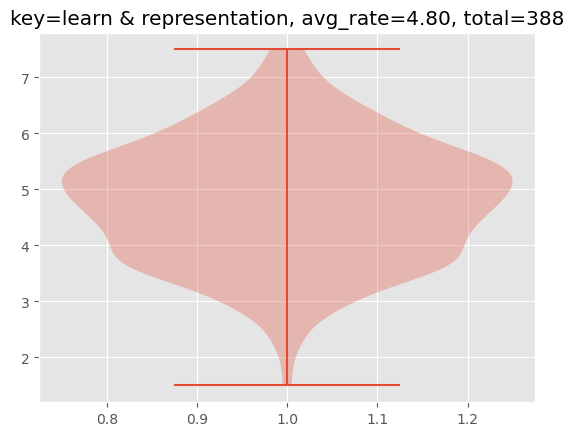

In [183]:
plt.violinplot(lis)
plt.title('key=learn & representation, avg_rate=%.2f, total=%d'%(np.mean(lis), len(lis)))
plt.show()

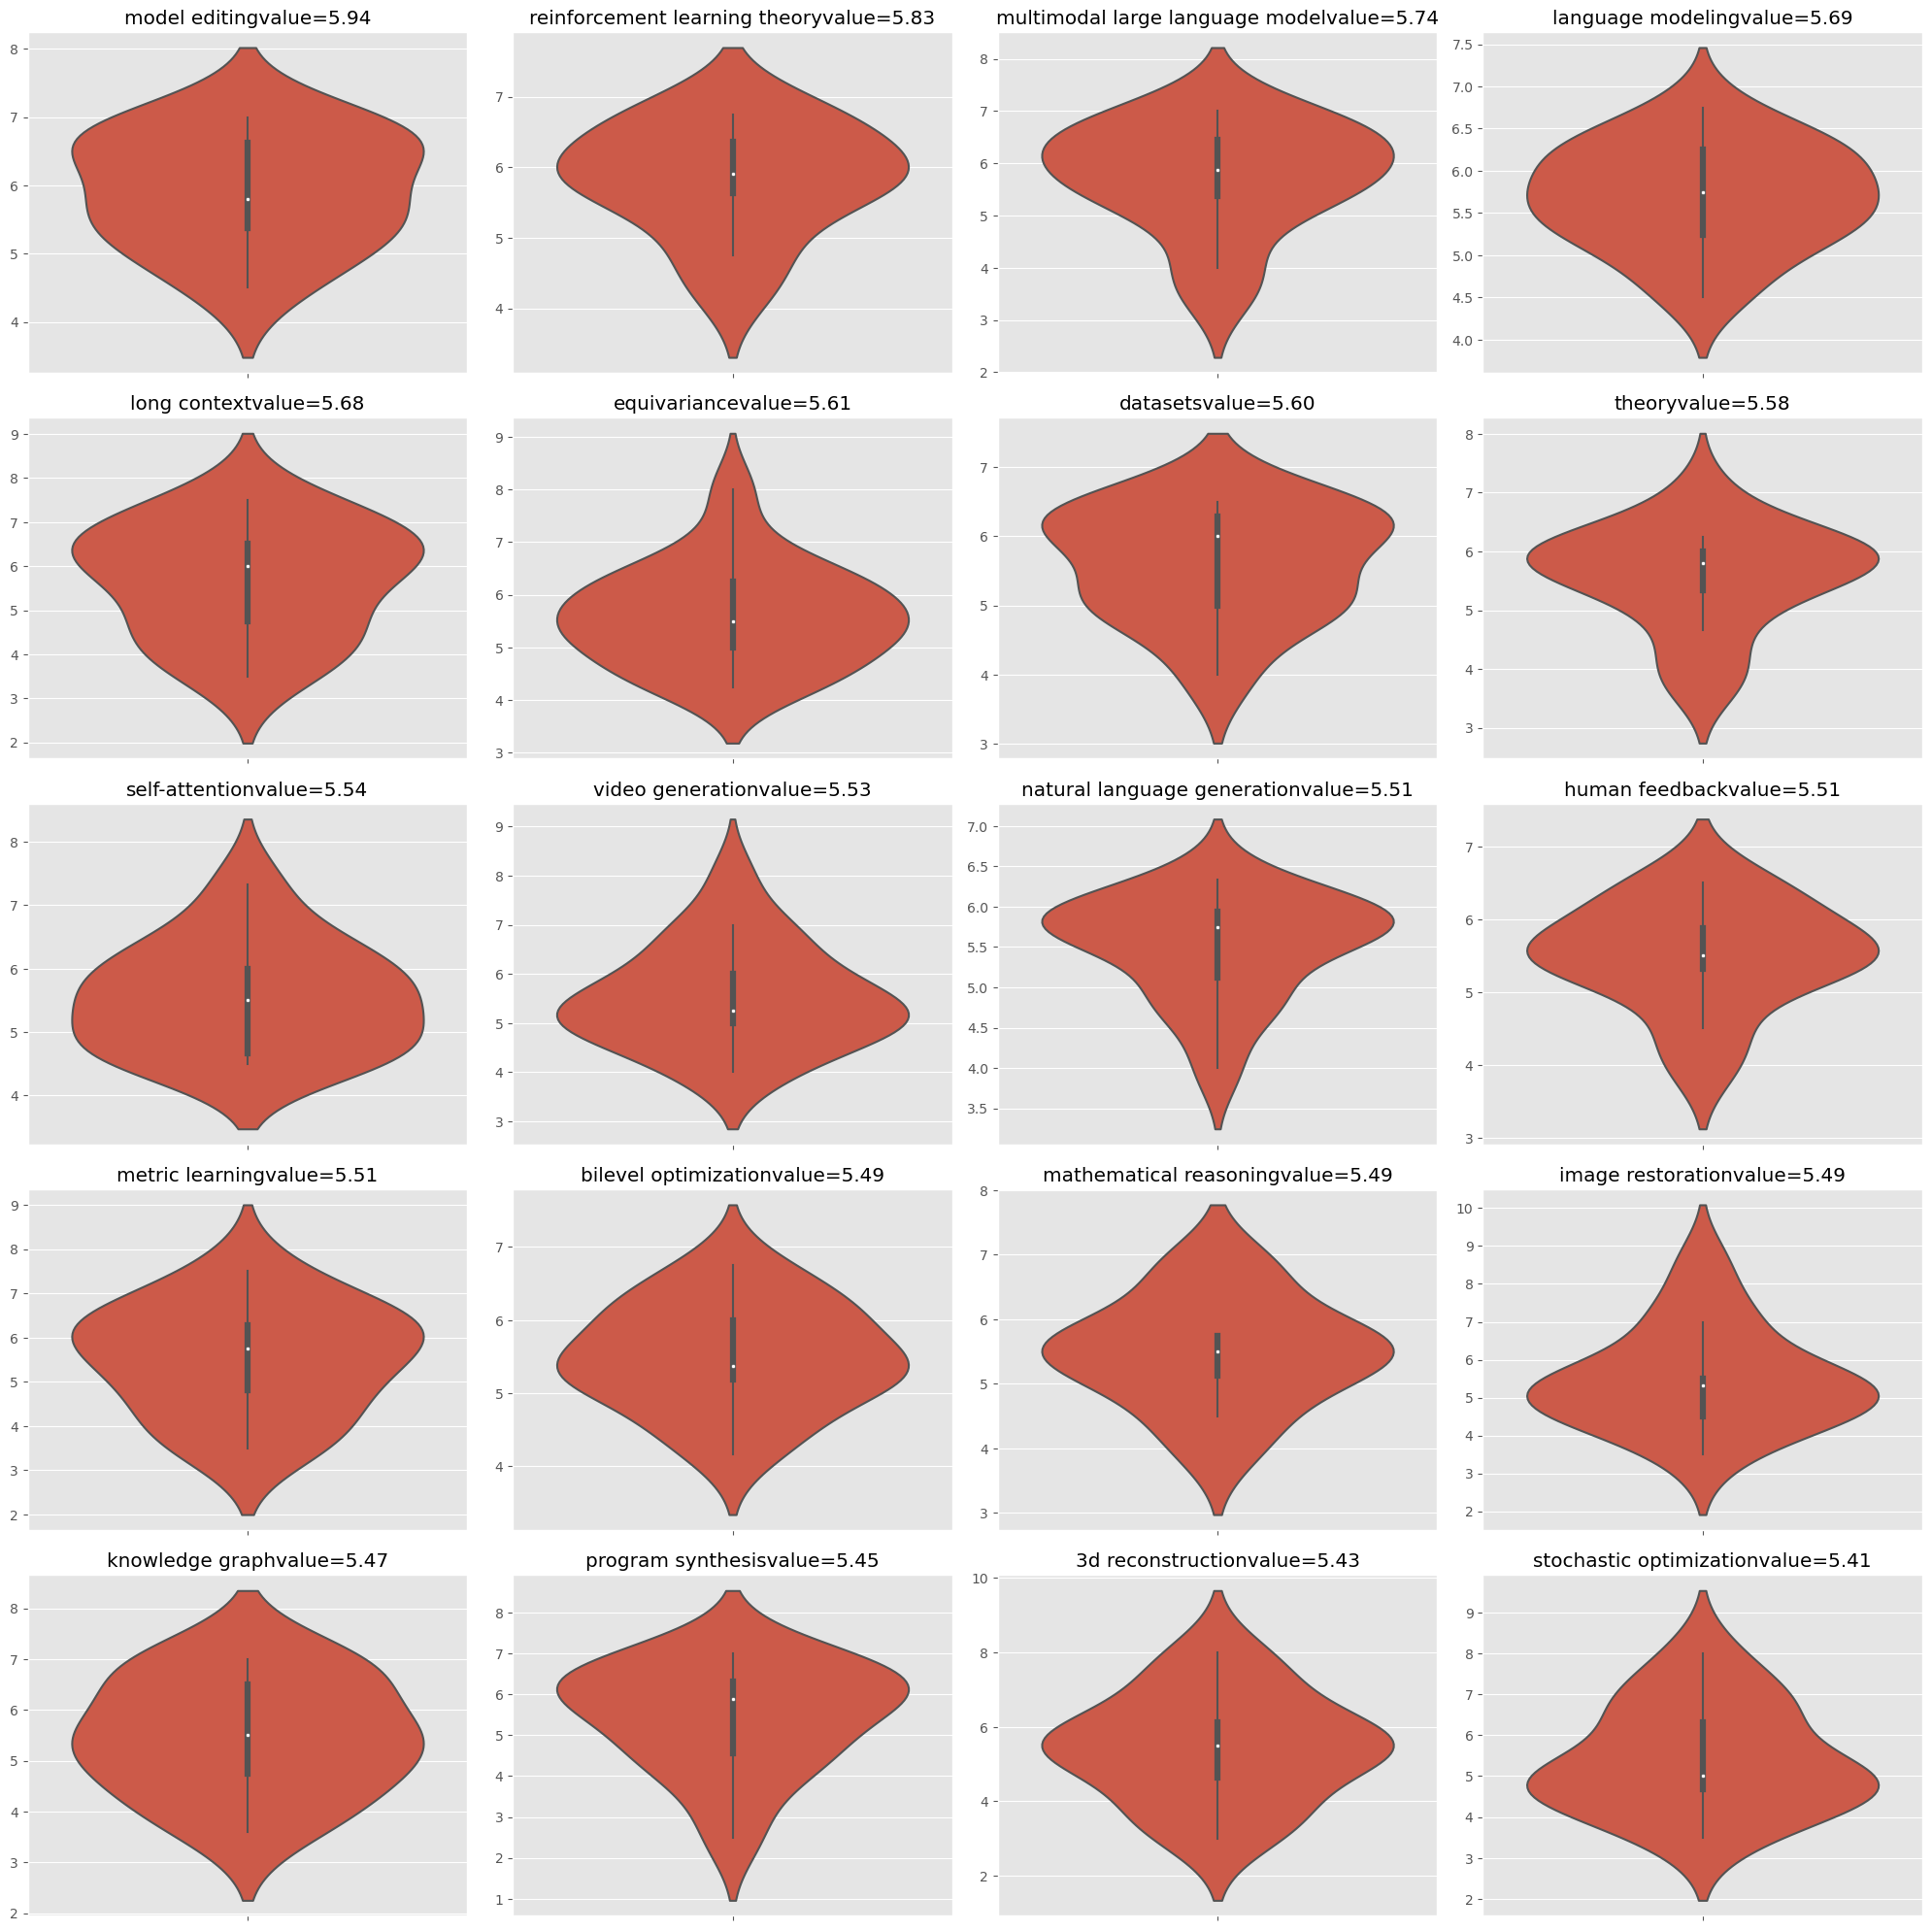

In [164]:
import seaborn as sns
sorted_keywords = {key: keyword_values[key] for key in keys_result[:20]}

# Number of rows and columns for subplots
n_rows = 5
n_cols = 4

# Create a figure with subplots
plt.figure(figsize=(20, 20))

# Loop through the sorted dictionary and create a subplot for each keyword
for i, (keyword, values) in enumerate(sorted_keywords.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    # plt.violinplot(values)
    sns.violinplot(y=values)
    plt.title(keyword + 'value=%.2f'%(np.mean(values)))

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
soup = BeautifulSoup(browser.page_source, 'html.parser')
pages = set()
for link in soup.find_all('a',href=re.compile("#")):
    if link.text == "»":
        print(link)

<a href="#" role="button"><span>»</span></a>


In [7]:
pages

{'1',
 '10',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'Active Submissions',
 'Feedback',
 'Recent Activity',
 'Show details',
 '»',
 '›'}